<a href="https://colab.research.google.com/github/souldrive7/ECP/blob/main/%E6%95%99%E5%B8%AB%E3%81%82%E3%82%8A%E5%AD%A6%E7%BF%92%E8%AA%B2%E9%A1%8C%E2%80%97%E6%9D%91%E6%9D%BE%E5%85%88%E7%94%9F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 教師あり学習 課題（村松先生）

### 氏名：後藤 晃郁

### 学籍番号：6025131

### 提出日：2025/5/15

# 課題

---

- 学習データ数，クラス数，特徴量数のいずれかを変化させたときのkNNの精度を比較する

- それぞれでkの値はcvを用いて最適化すること

- 結果は可視化して簡単な考察を加えること

- 提出物：jupyternotebook，pyファイル等，結果はnotebook上に示してもtext，pdf等で提出しても良い

---

# CIFAR-10データセットにおけるk-NN分類の精度検証

# ■はじめに■

CIFAR-10は10種類の物体画像からなる小規模なカラー画像データセットで、訓練画像50,000枚・テスト画像10,000枚が含まれる。

本課題では、k近傍法 (k-Nearest Neighbors, kNN) を用いてCIFAR-10画像の分類を行い、以下のポイントについて精度への影響を検証する：

- 実験1 学習データ数：訓練に用いるデータ数を変えた場合の精度変化
- 実験2 クラス数：分類するクラスの数を変えた場合の精度変化
- 実験3 特徴量数：画像あたりの特徴量次元を変えた場合の精度変化
- ハイパーパラメータである近傍数 k は交差検証 (CV) により最適化し、過学習を防ぐ

こうした検証を通じて、kNN分類器の性能特性や制約について分析し、モデル選択上の考察を行う。

---

#■ライブラリインポート・データ読込■

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import cv2

In [85]:
# インストール用
# !pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 24.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=83ed9fe87eeacb06fbbecf95ad3b2a0e5d16d1f00f212f11a9f7467d52951224
  Stored in directory: /root/.cache/pip/wheels/da/a1/71/b8faeb93276fed10edffcca20746f1ef6f8d9e071eee8425fc
Successfully built japanize-matplotlib


In [2]:
import japanize_matplotlib

In [3]:
# CIFAR-10読み込み
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = y_train.ravel(); y_test = y_test.ravel()
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']



---



# ■ベースライン■

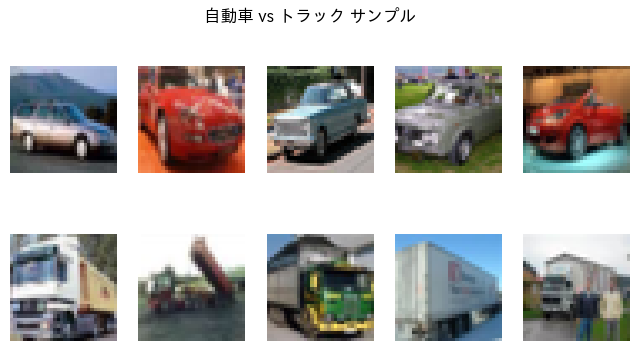

In [4]:
# (1) クラスごとのサンプル表示（自動車 vs トラック）
fig, axes = plt.subplots(2,5, figsize=(8,4))
for i, cls in enumerate([1,9]):  # 1=automobile, 9=truck
    imgs = x_train[y_train==cls][:5]
    for j,img in enumerate(imgs):
        ax = axes[i,j]
        ax.imshow(img); ax.axis('off')
    axes[i,0].set_ylabel(class_names[cls])
plt.suptitle("自動車 vs トラック サンプル"); plt.show()

# ■PCAによる2次元プロット■

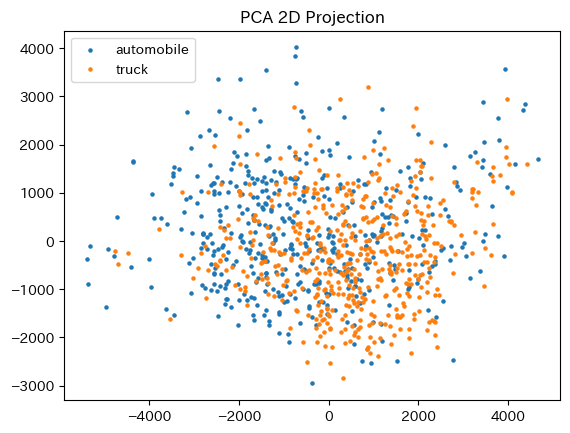

In [5]:
# 自動車とトラック 各500枚抽出
mask = np.isin(y_train, [1,9])
X = x_train[mask].reshape(-1, 3072)[:1000]
y = y_train[mask][:1000]
pca = PCA(n_components=2)
Z = pca.fit_transform(X)
plt.scatter(Z[y==1,0], Z[y==1,1], s=5, label='automobile')
plt.scatter(Z[y==9,0], Z[y==9,1], s=5, label='truck')
plt.legend(); plt.title("PCA 2D Projection"); plt.show()

---

# ■実験1：学習データ数による比較■

In [6]:
for n in [100, 500, 1000]:
    Xb, yb, Xt, yt = get_binary_data(n_train_per_cls=n)
    params, cv_score = optimize_knn(Xb.reshape(-1,3072), yb)
    acc = accuracy_score(yt, KNeighborsClassifier(**params)
                         .fit(Xb.reshape(-1,3072),yb)
                         .predict(Xt.reshape(-1,3072)))
    print(f"各クラス{n}枚: CV best {params}, CV={cv_score:.3f}, Test acc={acc:.3f}")


NameError: name 'get_binary_data' is not defined

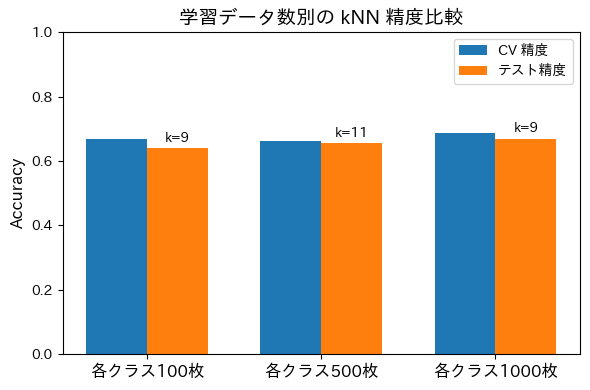

In [108]:
import numpy as np
import matplotlib.pyplot as plt

# 実験3の結果（手入力）
settings    = ['各クラス100枚', '各クラス500枚', '各クラス1000枚']
cv_scores   = [0.670,         0.664,          0.686]   # CV精度
test_scores = [0.640,         0.655,          0.670]   # テスト精度
best_ks     = [9,             11,             9]       # 最適 k

# プロット準備
x     = np.arange(len(settings))
width = 0.35

fig, ax = plt.subplots(figsize=(6,4))
bars_cv   = ax.bar(x - width/2, cv_scores,   width, label='CV 精度')
bars_test = ax.bar(x + width/2, test_scores, width, label='テスト精度')

# k 値をアノテーション
for idx, bar in enumerate(bars_test):
    ax.text(bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.01,
            f'k={best_ks[idx]}',
            ha='center', va='bottom', fontsize=10)

# 軸・凡例設定
ax.set_xticks(x)
ax.set_xticklabels(settings, fontsize=12)
ax.set_ylim(0, 1)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('学習データ数別の kNN 精度比較', fontsize=14)
ax.legend()

plt.tight_layout()
plt.show()


---

# ■実験2：クラス数による比較■

In [96]:
from sklearn.model_selection import train_test_split

def multiclass_data(n_classes, samples_per_class=500):
    """
    最初の n_classes クラスを対象に、
    各クラス samples_per_class 枚ずつサンプリングして返す。
    """
    # 使用するクラスIDリスト
    classes = list(range(n_classes))
    # マスクを作って画像とラベルを抽出
    mask_tr = np.isin(y_train, classes)
    X_full = x_train[mask_tr].reshape(-1, 3072)
    y_full = y_train[mask_tr]
    # 各クラスを均等に samples_per_class 枚ずつサンプリング
    Xb, _, yb, _ = train_test_split(
        X_full, y_full,
        train_size=n_classes * samples_per_class,
        stratify=y_full,
        random_state=0
    )
    # テストデータは全クラスからそのまま
    mask_te = np.isin(y_test, classes)
    Xt = x_test[mask_te].reshape(-1, 3072)
    yt = y_test[mask_te]
    return Xb, yb, Xt, yt

for k_classes in [2, 5, 10]:
    Xb, yb, Xt, yt = multiclass_data(k_classes, samples_per_class=500)
    # 念のため形状を確認
    print(f"{k_classes}クラス: train X={Xb.shape}, y={yb.shape}")
    # kNN最適化
    best_params, cv_score = optimize_knn(Xb, yb)
    # テスト精度
    clf = KNeighborsClassifier(**best_params).fit(Xb, yb)
    acc = accuracy_score(yt, clf.predict(Xt))
    print(f" → CV best={best_params}, CV精度={cv_score:.3f}, Test精度={acc:.3f}")

2クラス: train X=(1000, 3072), y=(1000,)
 → CV best={'n_neighbors': 3, 'weights': 'uniform'}, CV精度=0.656, Test精度=0.669
5クラス: train X=(2500, 3072), y=(2500,)
 → CV best={'n_neighbors': 3, 'weights': 'distance'}, CV精度=0.410, Test精度=0.416
10クラス: train X=(5000, 3072), y=(5000,)
 → CV best={'n_neighbors': 9, 'weights': 'distance'}, CV精度=0.283, Test精度=0.293


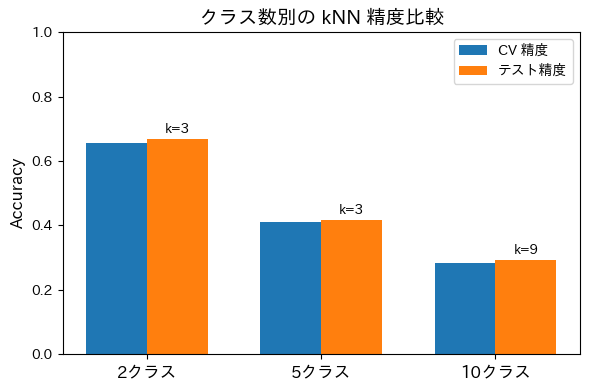

In [107]:
import numpy as np
import matplotlib.pyplot as plt

# 結果の定義
settings    = ['2クラス', '5クラス', '10クラス']
cv_scores   = [0.656,   0.410,   0.283]   # 実験から取得したCV精度
test_scores = [0.669,   0.416,   0.293]   # 実験から取得したテスト精度
best_ks     = [3,       3,       9]       # 実験から取得した最適 k

# グラフ描画準備
x     = np.arange(len(settings))
width = 0.35

fig, ax = plt.subplots(figsize=(6,4))
bars_cv   = ax.bar(x - width/2, cv_scores,   width, label='CV 精度')
bars_test = ax.bar(x + width/2, test_scores, width, label='テスト精度')

# 各棒の上に k の値を表示
for idx, bar in enumerate(bars_test):
    ax.text(bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.01,
            f'k={best_ks[idx]}',
            ha='center', va='bottom', fontsize=10)

# 軸ラベル・凡例など
ax.set_xticks(x)
ax.set_xticklabels(settings, fontsize=12)
ax.set_ylim(0, 1)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('クラス数別の kNN 精度比較', fontsize=14)
ax.legend()

plt.tight_layout()
plt.show()


---

# ■実験3：特徴量による比較■

In [92]:
def resize_flatten(X, size):
    return np.array([cv2.resize(img, (size,size)).flatten() for img in X])

def optimize_knn(X, y):
    params = {'n_neighbors':[3,5,7,9,11], 'weights':['uniform','distance']}
    gs = GridSearchCV(KNeighborsClassifier(), params, cv=4, n_jobs=-1)
    gs.fit(X, y)
    return gs.best_params_, gs.best_score_

# データ準備（自動車 vs トラック 各500 / テスト各100）
def get_binary_data(n_train_per_cls=500):
    mask = np.isin(y_train, [1,9])
    Xb = x_train[mask]; yb = y_train[mask]
    Xb, _, yb, _ = train_test_split(Xb, yb, train_size=2*n_train_per_cls,
                                     stratify=yb, random_state=0)
    mask_t = np.isin(y_test, [1,9])
    Xt, yt = x_test[mask_t], y_test[mask_t]
    Xt, _, yt, _ = train_test_split(Xt, yt, train_size=200,
                                     stratify=yt, random_state=0)
    return Xb, yb, Xt, yt

Xb, yb, Xt, yt = get_binary_data()
settings = {'PCA2': (PCA(n_components=2).fit_transform(Xb.reshape(-1,3072)),
                     PCA(n_components=2).fit_transform(Xt.reshape(-1,3072))),
            '16x16': (resize_flatten(Xb,16), resize_flatten(Xt,16)),
            '32x32': (Xb.reshape(-1,3072), Xt.reshape(-1,3072))}

for name, (Xtr, Xte) in settings.items():
    params, cv_score = optimize_knn(Xtr, yb)
    ypred = KNeighborsClassifier(**params).fit(Xtr, yb).predict(Xte)
    acc = accuracy_score(yt, ypred)
    print(f"{name}: CV best {params}, CV={cv_score:.3f}, Test acc={acc:.3f}")

PCA2: CV best {'n_neighbors': 5, 'weights': 'distance'}, CV=0.593, Test acc=0.600
16x16: CV best {'n_neighbors': 9, 'weights': 'distance'}, CV=0.676, Test acc=0.665
32x32: CV best {'n_neighbors': 11, 'weights': 'distance'}, CV=0.664, Test acc=0.655


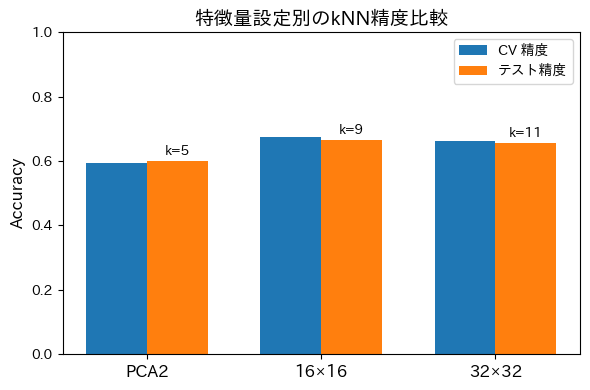

In [106]:
import numpy as np
import matplotlib.pyplot as plt

# 結果の定義
settings   = ['PCA2', '16×16', '32×32']
cv_scores  = [0.593, 0.676, 0.664]
test_accs  = [0.600, 0.665, 0.655]
best_ks    = [5,     9,     11]     # 各設定の最適 k

# グラフ描画
x     = np.arange(len(settings))
width = 0.35

fig, ax = plt.subplots(figsize=(6,4))
bars1 = ax.bar(x - width/2, cv_scores,  width, label='CV 精度')
bars2 = ax.bar(x + width/2, test_accs,  width, label='テスト精度')

# k のアノテーション
for idx, bar in enumerate(bars2):
    ax.text(bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.01,
            f'k={best_ks[idx]}',
            ha='center', va='bottom', fontsize=10)

# 軸・凡例設定
ax.set_xticks(x)
ax.set_xticklabels(settings, fontsize=12)
ax.set_ylim(0, 1)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('特徴量設定別のkNN精度比較', fontsize=14)
ax.legend()

plt.tight_layout()
plt.show()


# ■ご連携いただいたコードでの検証■

In [101]:
# 追加
# グリッドサーチ

from sklearn.model_selection import GridSearchCV

In [102]:
param = {'n_neighbors':[3,5,7,9,11],'weights':['uniform','distance']}
knn2 = KNeighborsClassifier()
gs = GridSearchCV(knn2, param, cv=4)
gs.fit(x_tr, y_tr.ravel())
res = pd.DataFrame.from_dict(gs.cv_results_)
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.003336,0.001136,0.087395,0.004868,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.680,0.660,0.624,0.592,0.639,0.033749,10
1,0.002435,0.000025,0.066994,0.003063,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",0.684,0.660,0.624,0.592,0.640,0.034986,9
2,0.002681,0.000179,0.084311,0.005978,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",0.708,0.696,0.680,0.664,0.687,0.016583,1
3,0.002069,0.000138,0.067206,0.008623,5,distance,"{'n_neighbors': 5, 'weights': 'distance'}",0.708,0.696,0.680,0.664,0.687,0.016583,1
4,0.002106,0.000146,0.075477,0.001664,7,uniform,"{'n_neighbors': 7, 'weights': 'uniform'}",0.660,0.676,0.688,0.660,0.671,0.011790,7
5,0.001948,0.000056,0.061924,0.004096,7,distance,"{'n_neighbors': 7, 'weights': 'distance'}",0.660,0.676,0.688,0.660,0.671,0.011790,7
6,0.001886,0.000081,0.136019,0.043418,9,uniform,"{'n_neighbors': 9, 'weights': 'uniform'}",0.676,0.680,0.692,0.664,0.678,0.010000,3
7,0.007413,0.003457,0.176007,0.020355,9,distance,"{'n_neighbors': 9, 'weights': 'distance'}",0.676,0.680,0.692,0.664,0.678,0.010000,3
8,0.003809,0.003131,0.226613,0.015385,11,uniform,"{'n_neighbors': 11, 'weights': 'uniform'}",0.724,0.668,0.680,0.636,0.677,0.031544,5
9,0.004141,0.003509,0.132332,0.041191,11,distance,"{'n_neighbors': 11, 'weights': 'distance'}",0.724,0.668,0.680,0.636,0.677,0.031544,5


In [103]:
gs.best_params_

{'n_neighbors': 5, 'weights': 'uniform'}

In [104]:
pr_te = gs.best_estimator_.predict(x_te) # knn2 = KNeighborsClassifier(**gs.best_params).fit(x_tr, y_tr).predict(x_te) （ベストのパラメータを使って学習したモデル）と同じ

In [105]:
print(confusion_matrix(y_te, pr_te))
print(classification_report(y_te, pr_te))

[[73 27]
 [37 63]]
              precision    recall  f1-score   support

           0       0.66      0.73      0.70       100
           1       0.70      0.63      0.66       100

    accuracy                           0.68       200
   macro avg       0.68      0.68      0.68       200
weighted avg       0.68      0.68      0.68       200



- ベストが n_neighbors=5 で、uniform、distanceのいずれも平均検証精度 0.687（rank=1）

- 次に良いのは n_neighbors=9 で精度 0.678（rank=3）

- さらに n_neighbors=11 の uniform が 0.677（rank=5）となっており、出力結果が合致